# Exploratory analysis

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Load data

In [2]:
covid = pd.read_csv('../data/time_series_covid19_deaths_global.csv')
covid.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/6/22,5/7/22,5/8/22,5/9/22,5/10/22,5/11/22,5/12/22,5/13/22,5/14/22,5/15/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,7684,7684,7684,7685,7685,7686,7686,7686,7687,7690
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3496,3496,3497,3497,3497,3497,3497,3497,3497,3497
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,6875,6875,6875,6875,6875,6875,6875,6875,6875,6875
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,153,153,153,153,153,153,153,153,153,153
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1900,1900,1900,1900,1900,1900,1900,1900,1900,1900


Convert dataframe from wide to long.

In [3]:
id_vars = covid.columns[0:4]
value_vars = covid.columns[4:]

covid_long = pd.melt(covid,
                    id_vars = id_vars,
                    value_vars = value_vars,
                    value_name = 'Deaths',
                    var_name = 'Date')

covid_long.head()

,Province/State,Country/Region,Lat,Long,Date,Deaths
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0
2,NaN,Algeria,28.03390,1.659600,1/22/20,0
3,NaN,Andorra,42.50630,1.521800,1/22/20,0
4,NaN,Angola,-11.20270,17.873900,1/22/20,0


Calculate number of deaths per day across all countries.

In [4]:
# -- Calculate total number of deaths per day (globally)
covid_deaths_day = covid_long.groupby('Date')['Deaths'] \
    .sum() \
    .to_frame() \
    .reset_index()

# -- Convert dates to date time format and sort by date
covid_deaths_day['Date'] = pd.to_datetime(covid_deaths_day['Date'])
covid_deaths_day = covid_deaths_day.sort_values('Date')
covid_deaths_day.head()

,Date,Deaths
28,2020-01-22,17
31,2020-01-23,18
34,2020-01-24,26
37,2020-01-25,42
40,2020-01-26,56


In [5]:
# Calculate cummulative deaths and plot
covid_deaths_day['Cummulative'] = covid_deaths_day['Deaths'].cumsum()
covid_deaths_day.head()

,Date,Deaths,Cummulative
28,2020-01-22,17,17
31,2020-01-23,18,35
34,2020-01-24,26,61
37,2020-01-25,42,103
40,2020-01-26,56,159


### Plot deaths along serie
Data seems to be non-stationary as it shows no season behaviour

Text(0.5, 1.0, 'Cummulative deaths')

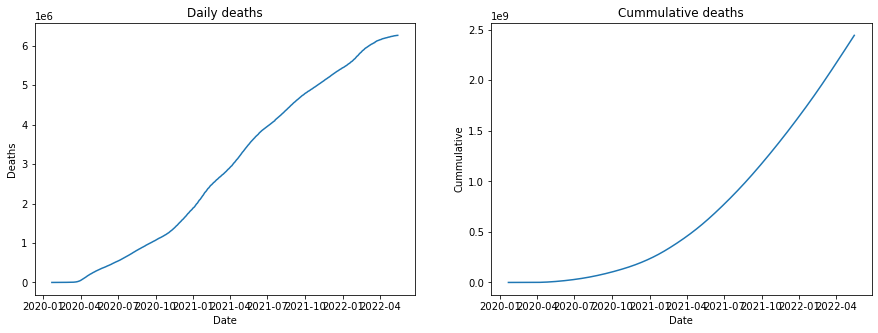

In [6]:
fig, axes = plt.subplots(1, 2,
    figsize = (15, 5))

sns.lineplot(covid_deaths_day,
            x = 'Date',
            y = 'Deaths',
            ax = axes[0])
axes[0].set_title('Daily deaths')

sns.lineplot(covid_deaths_day,
            x = 'Date',
            y = 'Cummulative',
            ax = axes[1])
axes[1].set_title('Cummulative deaths')

This time serie is clearly non-stationary as the mean (number of deaths per day) increases with time. This implies that we have to correct it to a stationary time serie.

### Time serie decomposition with statmodels

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

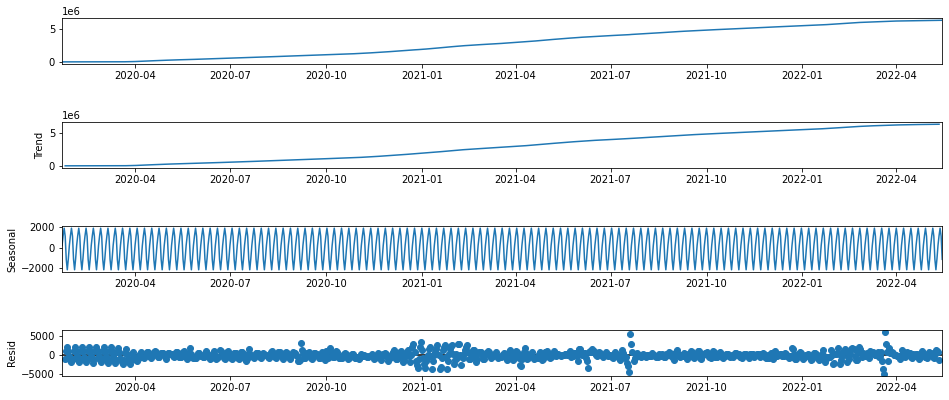

In [8]:
# Convert to serie
time_serie = pd.Series(data = list(covid_deaths_day['Deaths']),
                    index = covid_deaths_day['Date'])

seas_d = sm.tsa.seasonal_decompose(time_serie, model = 'add')
fig = seas_d.plot()
fig.set_figheight(6)
fig.set_figwidth(15)
plt.show()

The serie trends upwards and displays seasonal variation.

### Time serie transformation

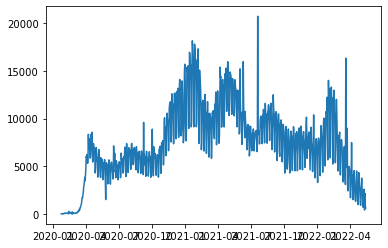

In [9]:
# First order differentiation
plt.plot(time_serie.diff())

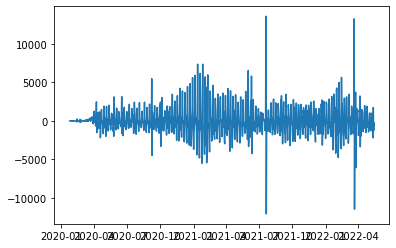

In [10]:
# Second order differentiation
plt.plot(time_serie.diff().diff())

In this second differentiation the mean reamins constant along the serie, however the variance not. Although this is not ideal, it can be employed for downstream analyses.
This second-order differentiation is basically the change of the change.

### Save second-order differentiation

In [11]:
time_serie_2nd = time_serie.diff().diff()

# Remove two initial time points as now are NaN
time_serie_2nd = time_serie_2nd[time_serie_2nd.notna()]

### Split into train and test

<AxesSubplot: xlabel='Date'>

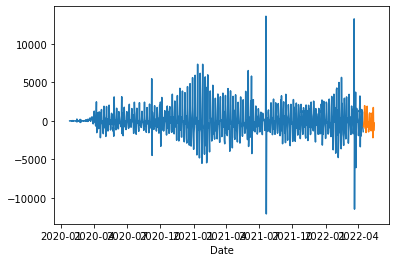

In [12]:
# Cutoff value to split in train and test
cutoff = '2022-04-15'

train = time_serie_2nd [time_serie_2nd.index <= cutoff]
test = time_serie_2nd [time_serie_2nd .index > cutoff]

# Plot train/test
sns.lineplot(train)
sns.lineplot(test)

Save train/test datasets

In [13]:
train.to_csv('../data/processed/train_time_serie_2nd_orderdiff.csv')
test.to_csv('../data/processed/test_time_serie_2nd_orderdiff.csv')